In [11]:
import os, time, json
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models


In [4]:
CSV_PATH = "train.csv"   # update path if needed
HEADER_NONE = True               # set True for the uploaded CSV (no header)
MAXLEN = 128                     # truncation length (as suggested)
BATCH_SIZE = 100
EPOCHS = 10                      # change to 10 for full runs; use 3 for quick demos
OPTIMIZER = "adam"
LOSS = "sparse_categorical_crossentropy"
RANDOM_STATE = 42

# Vocabulary levels to test
VOCAB_SIZES = [5000, 10000, 20000]

# Whether to test edited vs unedited top stop-words vocab (True = remove stopwords)
EDIT_VOCAB_MODES = [False, True]

# Models to run (we'll provide factory functions)
MODEL_NAMES = ["dense", "cnn1d", "simple_rnn", "lstm", "bilstm"]

In [6]:
if HEADER_NONE:
    df = pd.read_csv(CSV_PATH, header=None, encoding='utf-8')
else:
    df = pd.read_csv(CSV_PATH, encoding='utf-8')


In [8]:
texts = df[2].astype(str).tolist()
labels = df[0].astype(int).tolist()
label_set = sorted(list(set(labels)))
label_map = {lab:i for i,lab in enumerate(label_set)}
y = np.array([label_map[l] for l in labels])

In [ ]:
texts = df[2].astype(str).tolist()
labels = df[0].astype(int).tolist()
label_set = sorted(list(set(labels)))
label_map = {lab:i for i,lab in enumerate(label_set)}
y = np.array([label_map[l] for l in labels])

In [10]:
# Train/val/test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(texts, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1764706, random_state=RANDOM_STATE, stratify=y_temp)

print("Sizes: train/val/test =", len(X_train), len(X_val), len(X_test))

Sizes: train/val/test = 83999 18001 18000


In [ ]:
#Cleaning and Tokenization function
def basic_clean(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [13]:
X_train_clean = [basic_clean(s) for s in X_train]
X_val_clean   = [basic_clean(s) for s in X_val]
X_test_clean  = [basic_clean(s) for s in X_test]

In [14]:
X_train_clean[:5]

['opportunity one of nasa 39 s two mars rovers struggled to get up the side of endurance crater it spun its wheels digging deep holes in the stadium size crater 39 s quot sand trap',
 'uk retail giant tesco has decided to launch its own online music store complete with downloads from thousands of artists and one of the most open sharing schemes on the internet',
 'ap a benefit concert by the boss is bringing out big bids on ebay but some people offering tickets at several times their face value for an intimate performance sunday by bruce springsteen may be running afoul of anti scalping laws the face value of the tickets is 36 100 each',
 'ap israel s military said saturday that its 17 day incursion into the northern gaza strip struck a heavy blow against palestinian militants routinely firing makeshift rockets into the country s southern region',
 'halliburton hal nyse news research sank tuesday after the army chose not to extend a deadline for the company to explain its billing in ir

In [20]:
all_words = " ".join(X_train_clean).split()
word_counts = Counter(all_words)
most_common = [w for w,c in word_counts.most_common()]
STOPWORDS = set(most_common[:30])


In [21]:
def make_dense_model(vocab_size, embedding_dim=64, maxlen=MAXLEN, num_classes=len(label_set)):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model

def make_cnn1d_model(vocab_size, embedding_dim=64, maxlen=MAXLEN, num_classes=len(label_set)):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model

def make_simple_rnn_model(vocab_size, embedding_dim=64, maxlen=MAXLEN, num_classes=len(label_set)):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        layers.SimpleRNN(64),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model

def make_lstm_model(vocab_size, embedding_dim=64, maxlen=MAXLEN, num_classes=len(label_set), bidirectional=False):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)(inp)
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(64))(x)
    else:
        x = layers.LSTM(64)(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model


--- vocab_size: 5000 edited_vocab: False  ---
Training model: dense vocab: 5000 edited: False


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
840/840 - 9s - 10ms/step - accuracy: 0.6935 - loss: 0.7929 - val_accuracy: 0.8697 - val_loss: 0.3975
Epoch 2/10
840/840 - 7s - 8ms/step - accuracy: 0.8713 - loss: 0.3980 - val_accuracy: 0.8867 - val_loss: 0.3445
Epoch 3/10
840/840 - 7s - 8ms/step - accuracy: 0.8883 - loss: 0.3477 - val_accuracy: 0.8912 - val_loss: 0.3283
Epoch 4/10
840/840 - 7s - 9ms/step - accuracy: 0.8953 - loss: 0.3244 - val_accuracy: 0.8775 - val_loss: 0.3439
Epoch 5/10
840/840 - 7s - 8ms/step - accuracy: 0.8993 - loss: 0.3095 - val_accuracy: 0.8967 - val_loss: 0.3116
Epoch 6/10
840/840 - 7s - 8ms/step - accuracy: 0.9026 - loss: 0.2964 - val_accuracy: 0.8857 - val_loss: 0.3383
Epoch 7/10
840/840 - 7s - 8ms/step - accuracy: 0.9055 - loss: 0.2874 - val_accuracy: 0.8960 - val_loss: 0.3082
Epoch 8/10
840/840 - 7s - 8ms/step - accuracy: 0.9079 - loss: 0.2789 - val_accuracy: 0.8932 - val_loss: 0.3188
Epoch 9/10
840/840 - 6s - 8ms/step - accuracy: 0.9100 - loss: 0.2708 - val_accuracy: 0.8854 - val_loss: 0.3369


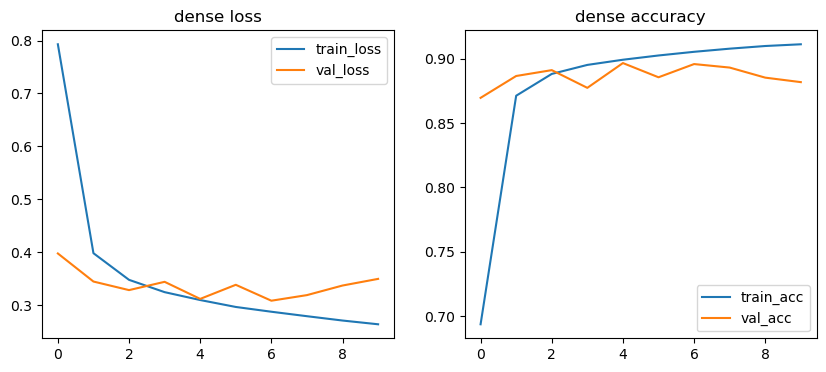

Training model: cnn1d vocab: 5000 edited: False
Epoch 1/10
840/840 - 36s - 42ms/step - accuracy: 0.8185 - loss: 0.5043 - val_accuracy: 0.8882 - val_loss: 0.3210
Epoch 2/10
840/840 - 32s - 39ms/step - accuracy: 0.9085 - loss: 0.2848 - val_accuracy: 0.8948 - val_loss: 0.3118
Epoch 3/10
840/840 - 33s - 40ms/step - accuracy: 0.9254 - loss: 0.2287 - val_accuracy: 0.8945 - val_loss: 0.3102
Epoch 4/10
840/840 - 33s - 39ms/step - accuracy: 0.9405 - loss: 0.1794 - val_accuracy: 0.8948 - val_loss: 0.3358
Epoch 5/10
840/840 - 32s - 39ms/step - accuracy: 0.9553 - loss: 0.1337 - val_accuracy: 0.8935 - val_loss: 0.3677
Epoch 6/10
840/840 - 33s - 39ms/step - accuracy: 0.9689 - loss: 0.0909 - val_accuracy: 0.8932 - val_loss: 0.4456
Epoch 7/10
840/840 - 32s - 38ms/step - accuracy: 0.9782 - loss: 0.0651 - val_accuracy: 0.8874 - val_loss: 0.4910
Epoch 8/10
840/840 - 32s - 38ms/step - accuracy: 0.9837 - loss: 0.0508 - val_accuracy: 0.8904 - val_loss: 0.5600
Epoch 9/10
840/840 - 36s - 42ms/step - accuracy:

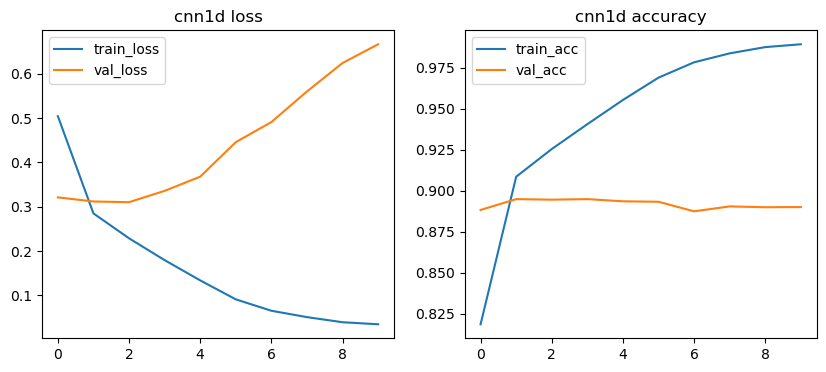

Training model: simple_rnn vocab: 5000 edited: False
Epoch 1/10
840/840 - 33s - 39ms/step - accuracy: 0.2576 - loss: 1.3878 - val_accuracy: 0.2548 - val_loss: 1.3862
Epoch 2/10
840/840 - 30s - 35ms/step - accuracy: 0.2512 - loss: 1.3871 - val_accuracy: 0.2501 - val_loss: 1.3866
Epoch 3/10
840/840 - 29s - 35ms/step - accuracy: 0.2546 - loss: 1.3865 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 4/10
840/840 - 29s - 35ms/step - accuracy: 0.2509 - loss: 1.3864 - val_accuracy: 0.2486 - val_loss: 1.3865
Epoch 5/10
840/840 - 30s - 35ms/step - accuracy: 0.2522 - loss: 1.3864 - val_accuracy: 0.2548 - val_loss: 1.3865
Epoch 6/10
840/840 - 30s - 35ms/step - accuracy: 0.2546 - loss: 1.3862 - val_accuracy: 0.2504 - val_loss: 1.3865
Epoch 7/10
840/840 - 30s - 35ms/step - accuracy: 0.2524 - loss: 1.3858 - val_accuracy: 0.2493 - val_loss: 1.3866
Epoch 8/10
840/840 - 29s - 34ms/step - accuracy: 0.2513 - loss: 1.3858 - val_accuracy: 0.2504 - val_loss: 1.3869
Epoch 9/10
840/840 - 31s - 36ms/step - accu

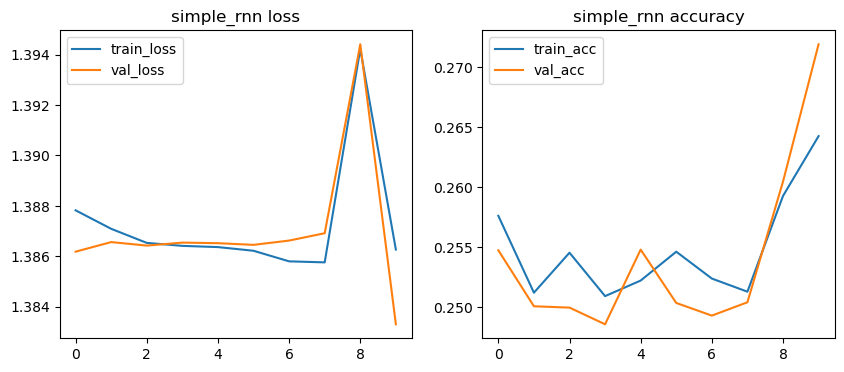

Training model: lstm vocab: 5000 edited: False
Epoch 1/10
840/840 - 100s - 119ms/step - accuracy: 0.2511 - loss: 1.3869 - val_accuracy: 0.2505 - val_loss: 1.3869
Epoch 2/10
840/840 - 97s - 115ms/step - accuracy: 0.2490 - loss: 1.3868 - val_accuracy: 0.2509 - val_loss: 1.3862
Epoch 3/10
840/840 - 94s - 112ms/step - accuracy: 0.2516 - loss: 1.3865 - val_accuracy: 0.2508 - val_loss: 1.3861
Epoch 4/10
840/840 - 97s - 115ms/step - accuracy: 0.2473 - loss: 1.3858 - val_accuracy: 0.2512 - val_loss: 1.3855
Epoch 5/10
840/840 - 97s - 115ms/step - accuracy: 0.2497 - loss: 1.3851 - val_accuracy: 0.3514 - val_loss: 1.3634
Epoch 6/10
840/840 - 95s - 113ms/step - accuracy: 0.4730 - loss: 1.0920 - val_accuracy: 0.5894 - val_loss: 0.8930
Epoch 7/10
840/840 - 95s - 113ms/step - accuracy: 0.6812 - loss: 0.7236 - val_accuracy: 0.8352 - val_loss: 0.4983
Epoch 8/10
840/840 - 94s - 112ms/step - accuracy: 0.8798 - loss: 0.3851 - val_accuracy: 0.8801 - val_loss: 0.3657
Epoch 9/10
840/840 - 94s - 112ms/step - 

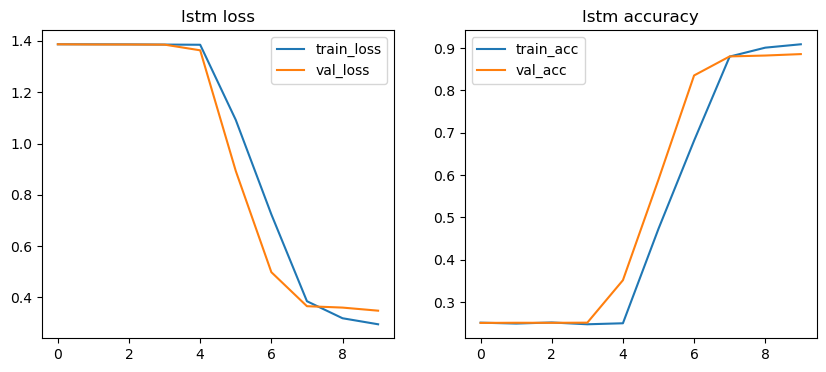

Training model: bilstm vocab: 5000 edited: False
Epoch 1/10
840/840 - 236s - 281ms/step - accuracy: 0.8207 - loss: 0.4892 - val_accuracy: 0.8879 - val_loss: 0.3321
Epoch 2/10
840/840 - 226s - 269ms/step - accuracy: 0.9056 - loss: 0.2876 - val_accuracy: 0.8921 - val_loss: 0.3086
Epoch 3/10
840/840 - 255s - 303ms/step - accuracy: 0.9141 - loss: 0.2555 - val_accuracy: 0.8911 - val_loss: 0.3074
Epoch 4/10
840/840 - 227s - 270ms/step - accuracy: 0.9219 - loss: 0.2312 - val_accuracy: 0.8911 - val_loss: 0.3151
Epoch 5/10
840/840 - 220s - 261ms/step - accuracy: 0.9275 - loss: 0.2133 - val_accuracy: 0.8926 - val_loss: 0.3205
Epoch 6/10
840/840 - 215s - 255ms/step - accuracy: 0.9324 - loss: 0.1966 - val_accuracy: 0.8924 - val_loss: 0.3288
Epoch 7/10
840/840 - 215s - 256ms/step - accuracy: 0.9378 - loss: 0.1803 - val_accuracy: 0.8916 - val_loss: 0.3299
Epoch 8/10
840/840 - 240s - 286ms/step - accuracy: 0.9419 - loss: 0.1683 - val_accuracy: 0.8927 - val_loss: 0.3476
Epoch 9/10
840/840 - 237s - 282

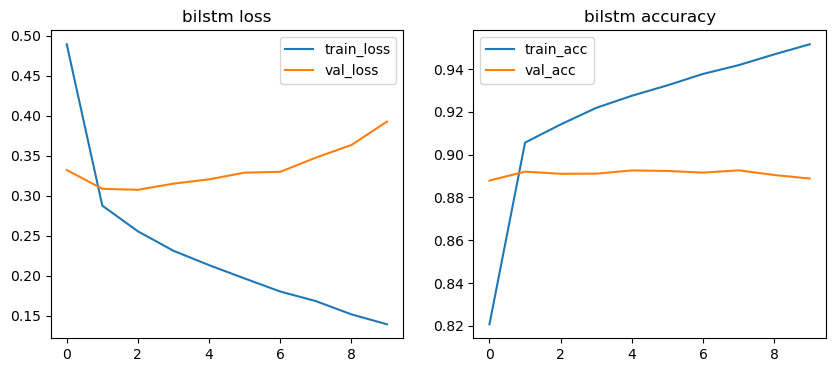


--- vocab_size: 5000 edited_vocab: True  ---
Training model: dense vocab: 5000 edited: True
Epoch 1/10
840/840 - 11s - 13ms/step - accuracy: 0.6438 - loss: 0.8775 - val_accuracy: 0.8750 - val_loss: 0.4040
Epoch 2/10
840/840 - 8s - 10ms/step - accuracy: 0.8662 - loss: 0.4185 - val_accuracy: 0.8465 - val_loss: 0.4146
Epoch 3/10
840/840 - 8s - 9ms/step - accuracy: 0.8851 - loss: 0.3595 - val_accuracy: 0.8901 - val_loss: 0.3413
Epoch 4/10
840/840 - 7s - 9ms/step - accuracy: 0.8917 - loss: 0.3379 - val_accuracy: 0.8666 - val_loss: 0.3677
Epoch 5/10
840/840 - 8s - 9ms/step - accuracy: 0.8965 - loss: 0.3180 - val_accuracy: 0.8738 - val_loss: 0.3734
Epoch 6/10
840/840 - 7s - 9ms/step - accuracy: 0.9014 - loss: 0.3019 - val_accuracy: 0.8865 - val_loss: 0.3403
Epoch 7/10
840/840 - 7s - 9ms/step - accuracy: 0.9038 - loss: 0.2931 - val_accuracy: 0.8908 - val_loss: 0.3177
Epoch 8/10
840/840 - 7s - 9ms/step - accuracy: 0.9048 - loss: 0.2866 - val_accuracy: 0.8908 - val_loss: 0.3243
Epoch 9/10
840/8

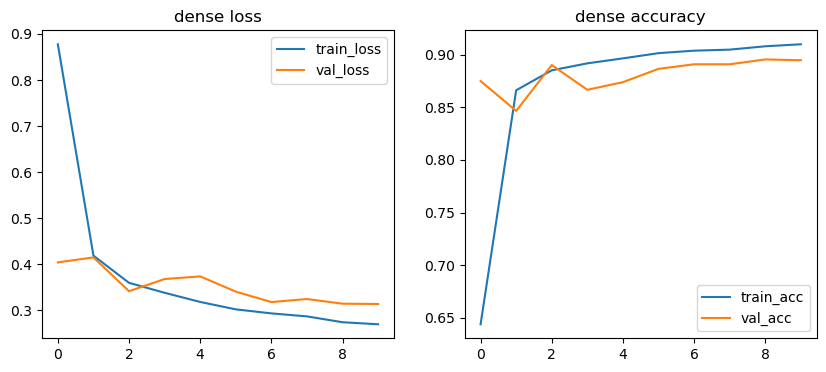

Training model: cnn1d vocab: 5000 edited: True
Epoch 1/10
840/840 - 39s - 46ms/step - accuracy: 0.8265 - loss: 0.4905 - val_accuracy: 0.8885 - val_loss: 0.3291
Epoch 2/10
840/840 - 36s - 43ms/step - accuracy: 0.9076 - loss: 0.2858 - val_accuracy: 0.8903 - val_loss: 0.3219
Epoch 3/10
840/840 - 45s - 53ms/step - accuracy: 0.9248 - loss: 0.2322 - val_accuracy: 0.8917 - val_loss: 0.3245
Epoch 4/10
840/840 - 33s - 40ms/step - accuracy: 0.9415 - loss: 0.1807 - val_accuracy: 0.8885 - val_loss: 0.3630
Epoch 5/10
840/840 - 33s - 39ms/step - accuracy: 0.9586 - loss: 0.1274 - val_accuracy: 0.8882 - val_loss: 0.3943
Epoch 6/10
840/840 - 34s - 40ms/step - accuracy: 0.9731 - loss: 0.0844 - val_accuracy: 0.8815 - val_loss: 0.4618
Epoch 7/10
840/840 - 33s - 39ms/step - accuracy: 0.9808 - loss: 0.0597 - val_accuracy: 0.8815 - val_loss: 0.5647
Epoch 8/10
840/840 - 33s - 39ms/step - accuracy: 0.9860 - loss: 0.0466 - val_accuracy: 0.8835 - val_loss: 0.6143
Epoch 9/10
840/840 - 33s - 39ms/step - accuracy: 

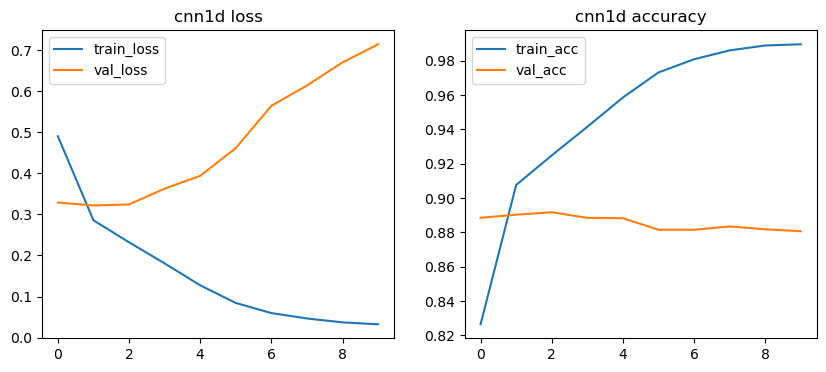

Training model: simple_rnn vocab: 5000 edited: True
Epoch 1/10
840/840 - 35s - 42ms/step - accuracy: 0.6567 - loss: 0.8631 - val_accuracy: 0.5587 - val_loss: 0.9707
Epoch 2/10
840/840 - 32s - 38ms/step - accuracy: 0.7911 - loss: 0.6380 - val_accuracy: 0.8085 - val_loss: 0.6059
Epoch 3/10
840/840 - 32s - 38ms/step - accuracy: 0.8004 - loss: 0.6182 - val_accuracy: 0.8031 - val_loss: 0.6090
Epoch 4/10
840/840 - 32s - 38ms/step - accuracy: 0.5579 - loss: 1.0239 - val_accuracy: 0.6664 - val_loss: 0.9190
Epoch 5/10
840/840 - 32s - 38ms/step - accuracy: 0.6812 - loss: 0.8897 - val_accuracy: 0.6403 - val_loss: 0.9630
Epoch 6/10
840/840 - 31s - 37ms/step - accuracy: 0.7135 - loss: 0.8356 - val_accuracy: 0.7069 - val_loss: 0.8345
Epoch 7/10
840/840 - 32s - 38ms/step - accuracy: 0.7166 - loss: 0.8214 - val_accuracy: 0.6602 - val_loss: 0.9379
Epoch 8/10
840/840 - 31s - 37ms/step - accuracy: 0.6257 - loss: 0.9890 - val_accuracy: 0.6582 - val_loss: 0.9258
Epoch 9/10
840/840 - 31s - 37ms/step - accur

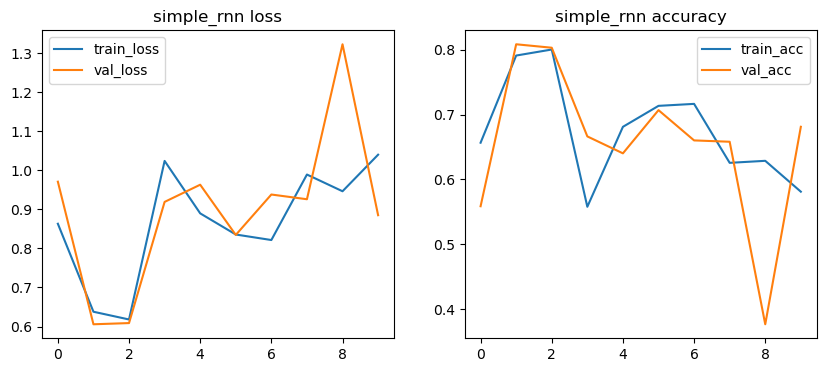

Training model: lstm vocab: 5000 edited: True
Epoch 1/10
840/840 - 104s - 123ms/step - accuracy: 0.2506 - loss: 1.3870 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 2/10
840/840 - 100s - 119ms/step - accuracy: 0.2474 - loss: 1.3868 - val_accuracy: 0.2502 - val_loss: 1.3865
Epoch 3/10
840/840 - 108s - 128ms/step - accuracy: 0.2502 - loss: 1.3867 - val_accuracy: 0.2502 - val_loss: 1.3863
Epoch 4/10
840/840 - 107s - 128ms/step - accuracy: 0.2504 - loss: 1.3865 - val_accuracy: 0.2502 - val_loss: 1.3864
Epoch 5/10
840/840 - 104s - 124ms/step - accuracy: 0.2516 - loss: 1.3864 - val_accuracy: 0.2503 - val_loss: 1.3864
Epoch 6/10
840/840 - 109s - 130ms/step - accuracy: 0.2509 - loss: 1.3864 - val_accuracy: 0.2504 - val_loss: 1.3860
Epoch 7/10
840/840 - 97s - 115ms/step - accuracy: 0.2499 - loss: 1.3863 - val_accuracy: 0.2503 - val_loss: 1.3861
Epoch 8/10
840/840 - 101s - 120ms/step - accuracy: 0.2501 - loss: 1.3863 - val_accuracy: 0.2502 - val_loss: 1.3860
Epoch 9/10
840/840 - 114s - 135ms/s

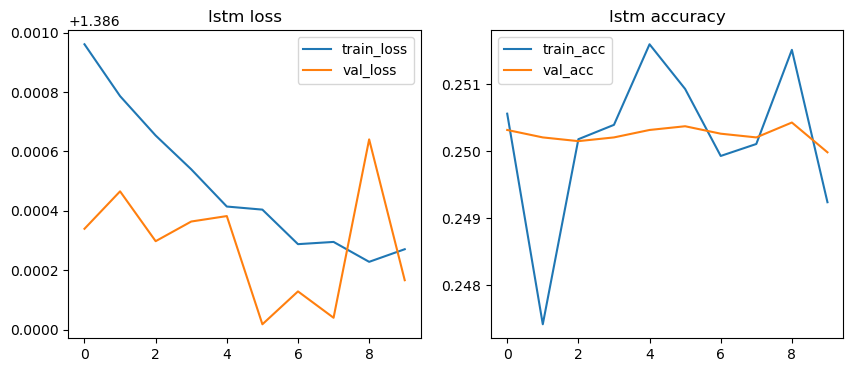

Training model: bilstm vocab: 5000 edited: True
Epoch 1/10
840/840 - 399s - 474ms/step - accuracy: 0.8443 - loss: 0.4426 - val_accuracy: 0.8940 - val_loss: 0.3124
Epoch 2/10
840/840 - 358s - 426ms/step - accuracy: 0.9073 - loss: 0.2773 - val_accuracy: 0.8915 - val_loss: 0.3090
Epoch 3/10
840/840 - 361s - 430ms/step - accuracy: 0.9165 - loss: 0.2465 - val_accuracy: 0.8911 - val_loss: 0.3187
Epoch 4/10
840/840 - 362s - 431ms/step - accuracy: 0.9226 - loss: 0.2260 - val_accuracy: 0.8918 - val_loss: 0.3171
Epoch 5/10
840/840 - 295s - 351ms/step - accuracy: 0.9285 - loss: 0.2058 - val_accuracy: 0.8908 - val_loss: 0.3317
Epoch 6/10
840/840 - 298s - 354ms/step - accuracy: 0.9334 - loss: 0.1903 - val_accuracy: 0.8873 - val_loss: 0.3332
Epoch 7/10
840/840 - 294s - 350ms/step - accuracy: 0.9386 - loss: 0.1743 - val_accuracy: 0.8858 - val_loss: 0.3478
Epoch 8/10
840/840 - 296s - 353ms/step - accuracy: 0.9450 - loss: 0.1571 - val_accuracy: 0.8863 - val_loss: 0.3781
Epoch 9/10
840/840 - 295s - 351m

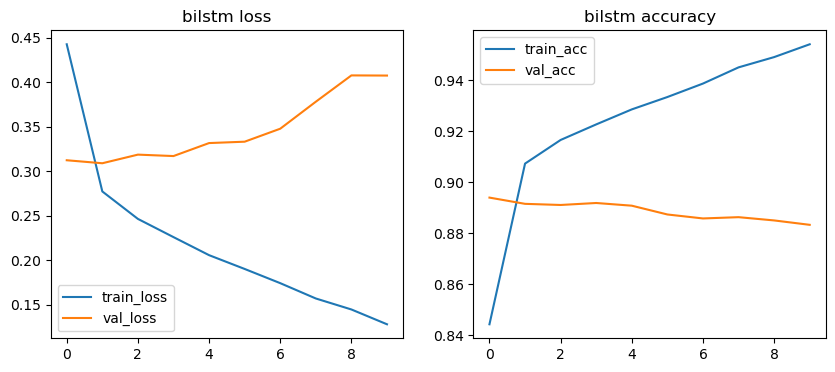


--- vocab_size: 10000 edited_vocab: False  ---
Training model: dense vocab: 10000 edited: False
Epoch 1/10
840/840 - 10s - 12ms/step - accuracy: 0.6803 - loss: 0.8144 - val_accuracy: 0.8760 - val_loss: 0.3851
Epoch 2/10
840/840 - 8s - 10ms/step - accuracy: 0.8791 - loss: 0.3814 - val_accuracy: 0.8747 - val_loss: 0.3772
Epoch 3/10
840/840 - 8s - 10ms/step - accuracy: 0.8969 - loss: 0.3246 - val_accuracy: 0.8960 - val_loss: 0.3154
Epoch 4/10
840/840 - 8s - 10ms/step - accuracy: 0.9064 - loss: 0.2939 - val_accuracy: 0.8967 - val_loss: 0.3050
Epoch 5/10
840/840 - 8s - 10ms/step - accuracy: 0.9136 - loss: 0.2677 - val_accuracy: 0.8993 - val_loss: 0.3095
Epoch 6/10
840/840 - 8s - 10ms/step - accuracy: 0.9165 - loss: 0.2576 - val_accuracy: 0.8928 - val_loss: 0.3139
Epoch 7/10
840/840 - 8s - 10ms/step - accuracy: 0.9208 - loss: 0.2459 - val_accuracy: 0.8948 - val_loss: 0.3132
Epoch 8/10
840/840 - 8s - 10ms/step - accuracy: 0.9251 - loss: 0.2300 - val_accuracy: 0.8976 - val_loss: 0.3111
Epoch 

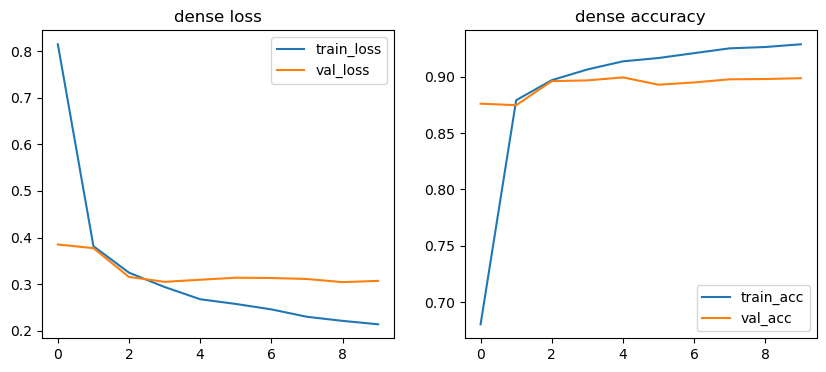

Training model: cnn1d vocab: 10000 edited: False
Epoch 1/10
840/840 - 36s - 43ms/step - accuracy: 0.8332 - loss: 0.4768 - val_accuracy: 0.8988 - val_loss: 0.2978
Epoch 2/10
840/840 - 34s - 40ms/step - accuracy: 0.9200 - loss: 0.2488 - val_accuracy: 0.8989 - val_loss: 0.2935
Epoch 3/10
840/840 - 34s - 40ms/step - accuracy: 0.9405 - loss: 0.1843 - val_accuracy: 0.8976 - val_loss: 0.3151
Epoch 4/10
840/840 - 34s - 41ms/step - accuracy: 0.9576 - loss: 0.1292 - val_accuracy: 0.8958 - val_loss: 0.3505
Epoch 5/10
840/840 - 35s - 42ms/step - accuracy: 0.9732 - loss: 0.0826 - val_accuracy: 0.8938 - val_loss: 0.4198
Epoch 6/10
840/840 - 34s - 41ms/step - accuracy: 0.9828 - loss: 0.0526 - val_accuracy: 0.8931 - val_loss: 0.4718
Epoch 7/10
840/840 - 35s - 41ms/step - accuracy: 0.9882 - loss: 0.0378 - val_accuracy: 0.8902 - val_loss: 0.5466
Epoch 8/10
840/840 - 34s - 40ms/step - accuracy: 0.9907 - loss: 0.0310 - val_accuracy: 0.8897 - val_loss: 0.6172
Epoch 9/10
840/840 - 35s - 41ms/step - accuracy

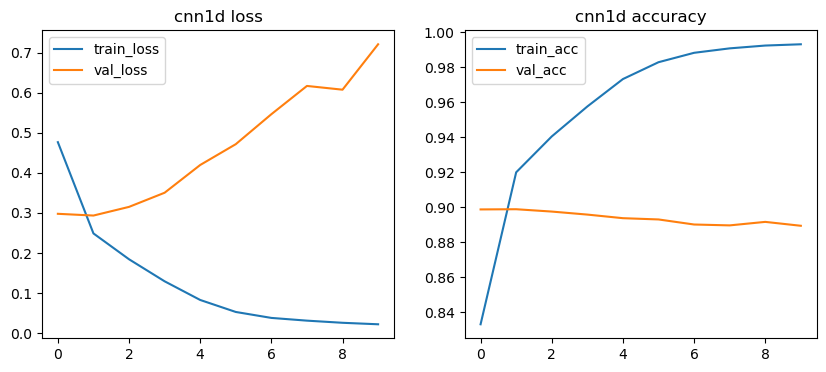

Training model: simple_rnn vocab: 10000 edited: False
Epoch 1/10
840/840 - 41s - 49ms/step - accuracy: 0.6640 - loss: 0.8881 - val_accuracy: 0.2503 - val_loss: 1.4042
Epoch 2/10
840/840 - 38s - 45ms/step - accuracy: 0.5689 - loss: 1.0598 - val_accuracy: 0.6451 - val_loss: 0.9502
Epoch 3/10
840/840 - 42s - 50ms/step - accuracy: 0.7157 - loss: 0.7978 - val_accuracy: 0.7476 - val_loss: 0.7141
Epoch 4/10
840/840 - 41s - 49ms/step - accuracy: 0.7717 - loss: 0.6723 - val_accuracy: 0.7587 - val_loss: 0.6938
Epoch 5/10
840/840 - 37s - 45ms/step - accuracy: 0.7960 - loss: 0.6164 - val_accuracy: 0.7825 - val_loss: 0.6486
Epoch 6/10
840/840 - 38s - 45ms/step - accuracy: 0.8123 - loss: 0.5831 - val_accuracy: 0.6357 - val_loss: 0.9353
Epoch 7/10
840/840 - 43s - 52ms/step - accuracy: 0.8315 - loss: 0.5358 - val_accuracy: 0.7809 - val_loss: 0.6562
Epoch 8/10
840/840 - 41s - 49ms/step - accuracy: 0.8424 - loss: 0.5106 - val_accuracy: 0.7761 - val_loss: 0.6795
Epoch 9/10
840/840 - 38s - 45ms/step - acc

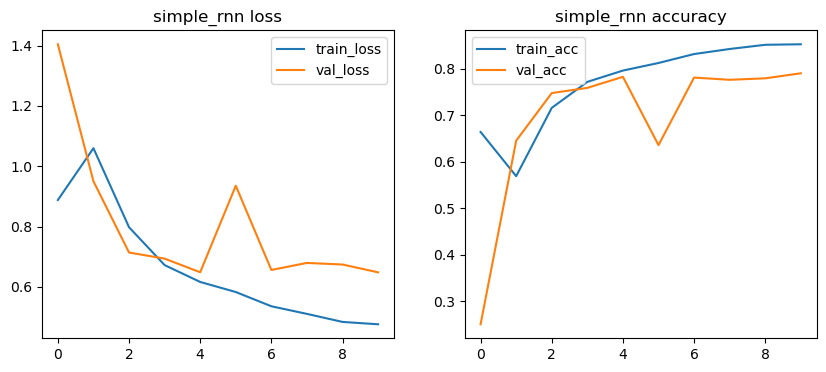

Training model: lstm vocab: 10000 edited: False
Epoch 1/10
840/840 - 107s - 127ms/step - accuracy: 0.2505 - loss: 1.3869 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/10
840/840 - 100s - 120ms/step - accuracy: 0.2487 - loss: 1.3877 - val_accuracy: 0.2510 - val_loss: 1.3861
Epoch 3/10
840/840 - 100s - 119ms/step - accuracy: 0.2536 - loss: 1.3866 - val_accuracy: 0.2510 - val_loss: 1.3866
Epoch 4/10
840/840 - 140s - 167ms/step - accuracy: 0.2514 - loss: 1.3856 - val_accuracy: 0.2524 - val_loss: 1.3851
Epoch 5/10
840/840 - 99s - 118ms/step - accuracy: 0.4639 - loss: 1.0951 - val_accuracy: 0.6071 - val_loss: 0.8211
Epoch 6/10
840/840 - 99s - 118ms/step - accuracy: 0.6569 - loss: 0.7404 - val_accuracy: 0.7029 - val_loss: 0.6440
Epoch 7/10
840/840 - 99s - 118ms/step - accuracy: 0.8424 - loss: 0.4520 - val_accuracy: 0.8794 - val_loss: 0.3745
Epoch 8/10
840/840 - 99s - 118ms/step - accuracy: 0.9109 - loss: 0.3045 - val_accuracy: 0.8914 - val_loss: 0.3524
Epoch 9/10
840/840 - 99s - 118ms/ste

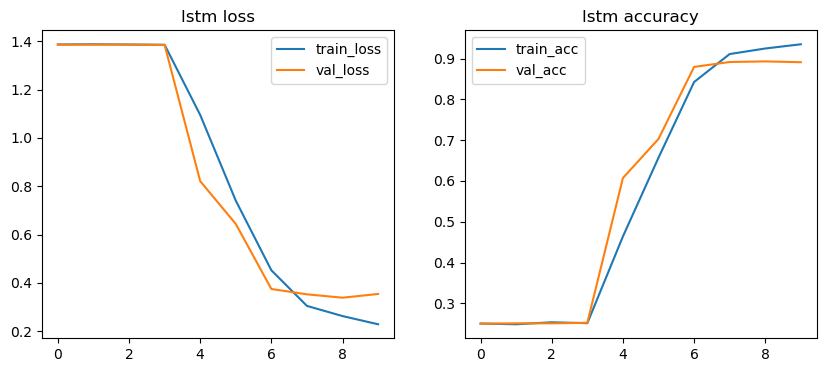

Training model: bilstm vocab: 10000 edited: False
Epoch 1/10
840/840 - 330s - 393ms/step - accuracy: 0.8262 - loss: 0.4773 - val_accuracy: 0.8957 - val_loss: 0.3090
Epoch 2/10
840/840 - 444s - 529ms/step - accuracy: 0.9160 - loss: 0.2557 - val_accuracy: 0.8978 - val_loss: 0.3015
Epoch 3/10
840/840 - 360s - 428ms/step - accuracy: 0.9292 - loss: 0.2167 - val_accuracy: 0.8938 - val_loss: 0.3092
Epoch 4/10
840/840 - 360s - 428ms/step - accuracy: 0.9359 - loss: 0.1907 - val_accuracy: 0.8937 - val_loss: 0.3177
Epoch 5/10
840/840 - 416s - 495ms/step - accuracy: 0.9435 - loss: 0.1666 - val_accuracy: 0.8951 - val_loss: 0.3294
Epoch 6/10
840/840 - 395s - 470ms/step - accuracy: 0.9502 - loss: 0.1459 - val_accuracy: 0.8918 - val_loss: 0.3574
Epoch 7/10
840/840 - 432s - 515ms/step - accuracy: 0.9565 - loss: 0.1268 - val_accuracy: 0.8889 - val_loss: 0.3883
Epoch 8/10
840/840 - 323s - 384ms/step - accuracy: 0.9622 - loss: 0.1097 - val_accuracy: 0.8897 - val_loss: 0.4528
Epoch 9/10
840/840 - 333s - 39

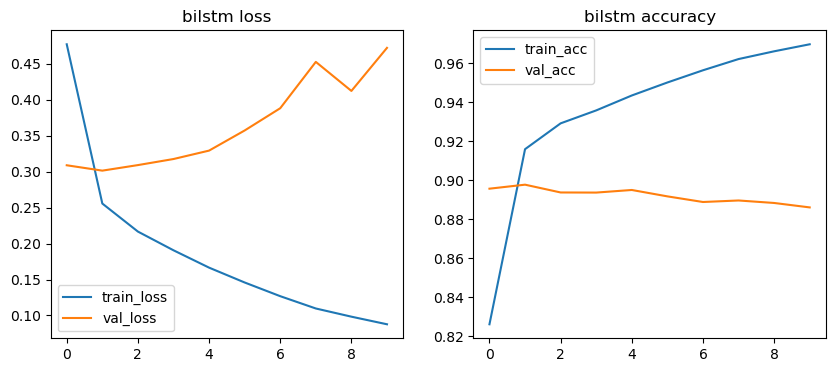


--- vocab_size: 10000 edited_vocab: True  ---
Training model: dense vocab: 10000 edited: True
Epoch 1/10
840/840 - 13s - 15ms/step - accuracy: 0.6724 - loss: 0.8303 - val_accuracy: 0.8602 - val_loss: 0.4152
Epoch 2/10
840/840 - 10s - 12ms/step - accuracy: 0.8773 - loss: 0.3865 - val_accuracy: 0.8863 - val_loss: 0.3517
Epoch 3/10
840/840 - 10s - 11ms/step - accuracy: 0.8956 - loss: 0.3301 - val_accuracy: 0.8629 - val_loss: 0.4004
Epoch 4/10
840/840 - 9s - 11ms/step - accuracy: 0.9050 - loss: 0.2977 - val_accuracy: 0.8722 - val_loss: 0.3806
Epoch 5/10
840/840 - 10s - 12ms/step - accuracy: 0.9093 - loss: 0.2834 - val_accuracy: 0.8900 - val_loss: 0.3282
Epoch 6/10
840/840 - 10s - 11ms/step - accuracy: 0.9152 - loss: 0.2629 - val_accuracy: 0.8746 - val_loss: 0.3765
Epoch 7/10
840/840 - 10s - 12ms/step - accuracy: 0.9171 - loss: 0.2526 - val_accuracy: 0.8981 - val_loss: 0.3082
Epoch 8/10
840/840 - 10s - 11ms/step - accuracy: 0.9214 - loss: 0.2409 - val_accuracy: 0.8987 - val_loss: 0.3064
Ep

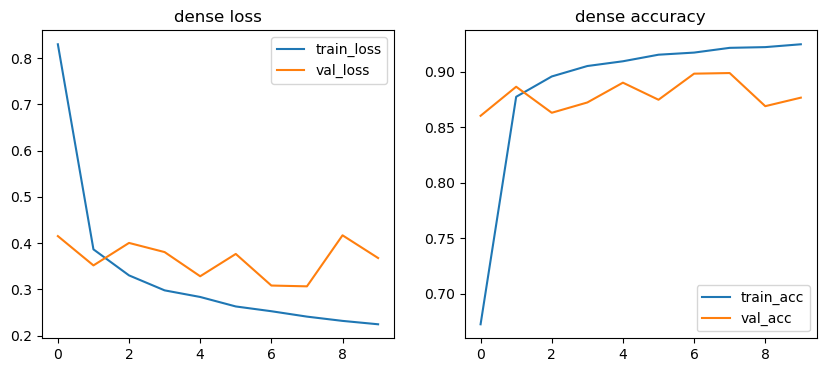

Training model: cnn1d vocab: 10000 edited: True
Epoch 1/10
840/840 - 45s - 54ms/step - accuracy: 0.8325 - loss: 0.4799 - val_accuracy: 0.8985 - val_loss: 0.3062
Epoch 2/10
840/840 - 40s - 48ms/step - accuracy: 0.9188 - loss: 0.2549 - val_accuracy: 0.8987 - val_loss: 0.3065
Epoch 3/10
840/840 - 40s - 47ms/step - accuracy: 0.9396 - loss: 0.1906 - val_accuracy: 0.8933 - val_loss: 0.3305
Epoch 4/10
840/840 - 52s - 61ms/step - accuracy: 0.9586 - loss: 0.1320 - val_accuracy: 0.8878 - val_loss: 0.3747
Epoch 5/10
840/840 - 52s - 62ms/step - accuracy: 0.9745 - loss: 0.0825 - val_accuracy: 0.8876 - val_loss: 0.4442
Epoch 6/10
840/840 - 58s - 69ms/step - accuracy: 0.9838 - loss: 0.0547 - val_accuracy: 0.8861 - val_loss: 0.5118
Epoch 7/10
840/840 - 53s - 63ms/step - accuracy: 0.9885 - loss: 0.0400 - val_accuracy: 0.8867 - val_loss: 0.5892
Epoch 8/10
840/840 - 52s - 62ms/step - accuracy: 0.9908 - loss: 0.0319 - val_accuracy: 0.8844 - val_loss: 0.6679
Epoch 9/10
840/840 - 67s - 80ms/step - accuracy:

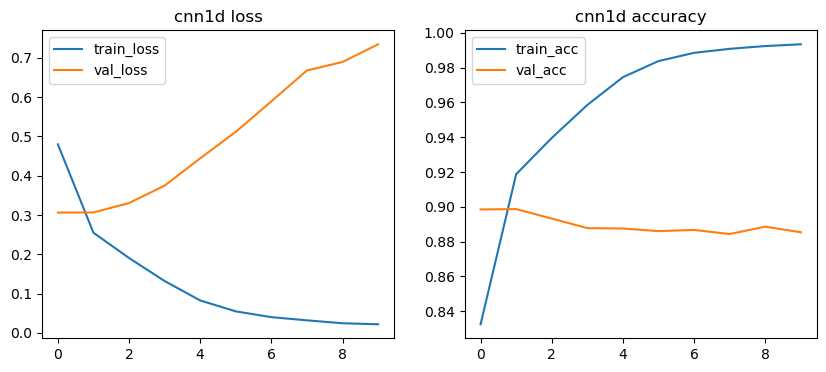

Training model: simple_rnn vocab: 10000 edited: True
Epoch 1/10
840/840 - 60s - 71ms/step - accuracy: 0.6593 - loss: 0.8693 - val_accuracy: 0.6434 - val_loss: 0.9071
Epoch 2/10
840/840 - 55s - 66ms/step - accuracy: 0.7299 - loss: 0.8109 - val_accuracy: 0.7511 - val_loss: 0.7706
Epoch 3/10
840/840 - 56s - 67ms/step - accuracy: 0.6399 - loss: 0.9625 - val_accuracy: 0.5960 - val_loss: 1.0242
Epoch 4/10
840/840 - 76s - 91ms/step - accuracy: 0.6688 - loss: 0.9160 - val_accuracy: 0.6785 - val_loss: 0.8922
Epoch 5/10
840/840 - 62s - 74ms/step - accuracy: 0.7034 - loss: 0.8450 - val_accuracy: 0.7010 - val_loss: 0.8578
Epoch 6/10
840/840 - 60s - 71ms/step - accuracy: 0.7496 - loss: 0.7448 - val_accuracy: 0.7797 - val_loss: 0.6703
Epoch 7/10
840/840 - 57s - 68ms/step - accuracy: 0.7941 - loss: 0.6235 - val_accuracy: 0.6561 - val_loss: 0.9163
Epoch 8/10
840/840 - 58s - 69ms/step - accuracy: 0.7288 - loss: 0.8055 - val_accuracy: 0.7017 - val_loss: 0.8701
Epoch 9/10
840/840 - 81s - 96ms/step - accu

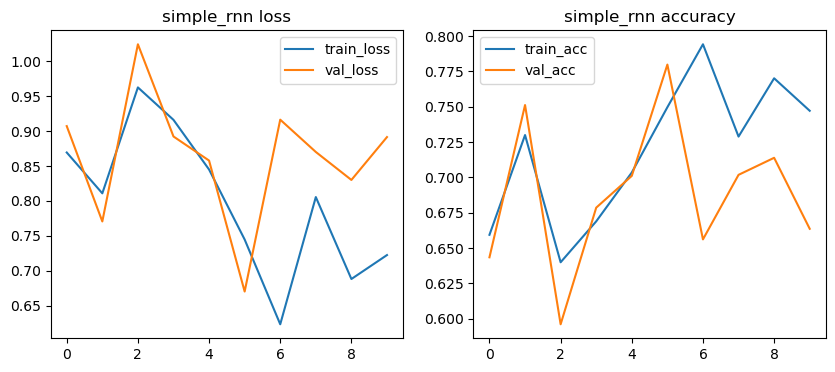

Training model: lstm vocab: 10000 edited: True
Epoch 1/10
840/840 - 140s - 167ms/step - accuracy: 0.2486 - loss: 1.3870 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 2/10
840/840 - 143s - 171ms/step - accuracy: 0.2473 - loss: 1.3868 - val_accuracy: 0.2502 - val_loss: 1.3865
Epoch 3/10
840/840 - 157s - 187ms/step - accuracy: 0.2496 - loss: 1.3866 - val_accuracy: 0.2502 - val_loss: 1.3863
Epoch 4/10
840/840 - 165s - 196ms/step - accuracy: 0.2486 - loss: 1.3866 - val_accuracy: 0.2502 - val_loss: 1.3863
Epoch 5/10
840/840 - 145s - 173ms/step - accuracy: 0.2502 - loss: 1.3865 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 6/10
840/840 - 136s - 162ms/step - accuracy: 0.2487 - loss: 1.3865 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 7/10
840/840 - 118s - 141ms/step - accuracy: 0.2498 - loss: 1.3868 - val_accuracy: 0.2502 - val_loss: 1.3863
Epoch 8/10
840/840 - 118s - 141ms/step - accuracy: 0.2493 - loss: 1.3864 - val_accuracy: 0.2504 - val_loss: 1.3860
Epoch 9/10
840/840 - 120s - 142ms

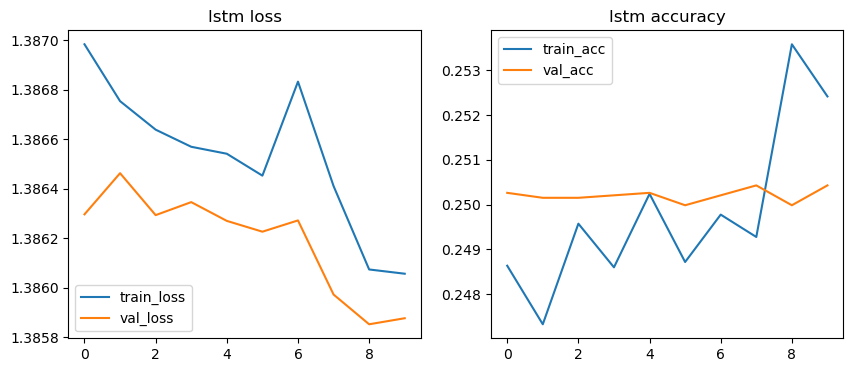

Training model: bilstm vocab: 10000 edited: True
Epoch 1/10
840/840 - 355s - 423ms/step - accuracy: 0.8502 - loss: 0.4368 - val_accuracy: 0.9004 - val_loss: 0.2958
Epoch 2/10
840/840 - 361s - 430ms/step - accuracy: 0.9187 - loss: 0.2471 - val_accuracy: 0.8975 - val_loss: 0.2984
Epoch 3/10
840/840 - 383s - 456ms/step - accuracy: 0.9306 - loss: 0.2083 - val_accuracy: 0.8961 - val_loss: 0.3132
Epoch 4/10
840/840 - 329s - 392ms/step - accuracy: 0.9398 - loss: 0.1803 - val_accuracy: 0.8934 - val_loss: 0.3203
Epoch 5/10
840/840 - 330s - 393ms/step - accuracy: 0.9467 - loss: 0.1561 - val_accuracy: 0.8933 - val_loss: 0.3441
Epoch 6/10
840/840 - 339s - 403ms/step - accuracy: 0.9551 - loss: 0.1335 - val_accuracy: 0.8887 - val_loss: 0.3843
Epoch 7/10
840/840 - 389s - 463ms/step - accuracy: 0.9610 - loss: 0.1134 - val_accuracy: 0.8847 - val_loss: 0.4167
Epoch 8/10
840/840 - 331s - 394ms/step - accuracy: 0.9659 - loss: 0.0989 - val_accuracy: 0.8853 - val_loss: 0.4377
Epoch 9/10
840/840 - 331s - 395

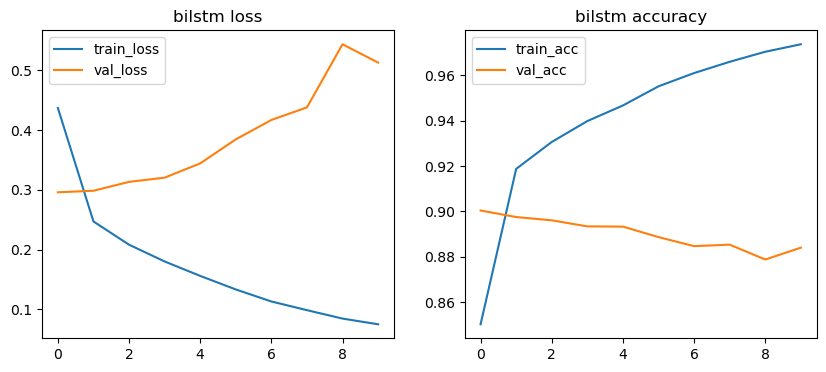


--- vocab_size: 20000 edited_vocab: False  ---
Training model: dense vocab: 20000 edited: False
Epoch 1/10
840/840 - 14s - 17ms/step - accuracy: 0.6771 - loss: 0.8043 - val_accuracy: 0.8668 - val_loss: 0.4129
Epoch 2/10
840/840 - 12s - 14ms/step - accuracy: 0.8832 - loss: 0.3679 - val_accuracy: 0.8923 - val_loss: 0.3220
Epoch 3/10
840/840 - 12s - 14ms/step - accuracy: 0.9042 - loss: 0.3054 - val_accuracy: 0.8926 - val_loss: 0.3096
Epoch 4/10
840/840 - 12s - 14ms/step - accuracy: 0.9129 - loss: 0.2726 - val_accuracy: 0.8851 - val_loss: 0.3416
Epoch 5/10
840/840 - 21s - 25ms/step - accuracy: 0.9202 - loss: 0.2507 - val_accuracy: 0.9012 - val_loss: 0.2909
Epoch 6/10
840/840 - 12s - 15ms/step - accuracy: 0.9276 - loss: 0.2248 - val_accuracy: 0.9044 - val_loss: 0.2872
Epoch 7/10
840/840 - 13s - 15ms/step - accuracy: 0.9318 - loss: 0.2117 - val_accuracy: 0.9009 - val_loss: 0.3051
Epoch 8/10
840/840 - 12s - 15ms/step - accuracy: 0.9342 - loss: 0.2014 - val_accuracy: 0.9037 - val_loss: 0.3008

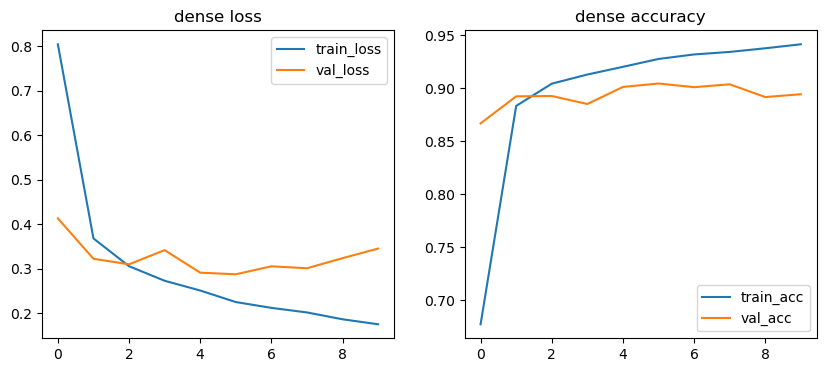

Training model: cnn1d vocab: 20000 edited: False
Epoch 1/10
840/840 - 44s - 52ms/step - accuracy: 0.8245 - loss: 0.4895 - val_accuracy: 0.8990 - val_loss: 0.2993
Epoch 2/10
840/840 - 41s - 49ms/step - accuracy: 0.9256 - loss: 0.2360 - val_accuracy: 0.9004 - val_loss: 0.2914
Epoch 3/10
840/840 - 41s - 49ms/step - accuracy: 0.9489 - loss: 0.1593 - val_accuracy: 0.8982 - val_loss: 0.3249
Epoch 4/10
840/840 - 83s - 99ms/step - accuracy: 0.9665 - loss: 0.1027 - val_accuracy: 0.8942 - val_loss: 0.3901
Epoch 5/10
840/840 - 82s - 98ms/step - accuracy: 0.9799 - loss: 0.0646 - val_accuracy: 0.8932 - val_loss: 0.4305
Epoch 6/10
840/840 - 42s - 50ms/step - accuracy: 0.9862 - loss: 0.0438 - val_accuracy: 0.8943 - val_loss: 0.4744
Epoch 7/10
840/840 - 42s - 50ms/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.8935 - val_loss: 0.5700
Epoch 8/10
840/840 - 82s - 97ms/step - accuracy: 0.9925 - loss: 0.0258 - val_accuracy: 0.8909 - val_loss: 0.6582
Epoch 9/10
840/840 - 41s - 49ms/step - accuracy

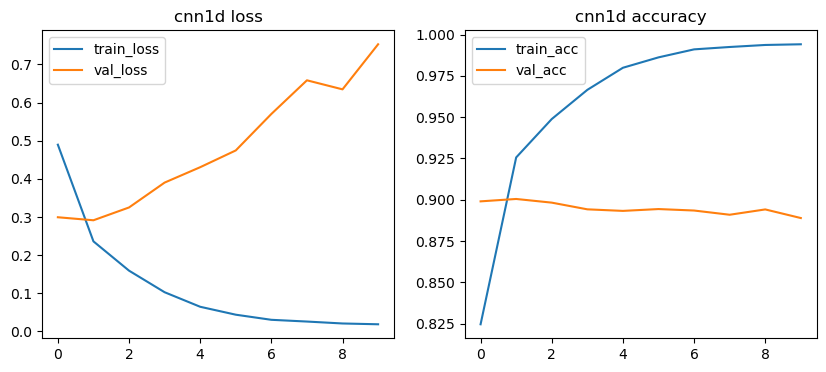

Training model: simple_rnn vocab: 20000 edited: False
Epoch 1/10
840/840 - 56s - 66ms/step - accuracy: 0.2514 - loss: 1.3885 - val_accuracy: 0.2494 - val_loss: 1.3861
Epoch 2/10
840/840 - 52s - 62ms/step - accuracy: 0.2525 - loss: 1.3868 - val_accuracy: 0.2505 - val_loss: 1.3863
Epoch 3/10
840/840 - 51s - 60ms/step - accuracy: 0.2506 - loss: 1.3864 - val_accuracy: 0.2506 - val_loss: 1.3863
Epoch 4/10
840/840 - 50s - 60ms/step - accuracy: 0.2520 - loss: 1.3865 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 5/10
840/840 - 52s - 62ms/step - accuracy: 0.2505 - loss: 1.3860 - val_accuracy: 0.2505 - val_loss: 1.3868
Epoch 6/10
840/840 - 53s - 63ms/step - accuracy: 0.2496 - loss: 1.3862 - val_accuracy: 0.2500 - val_loss: 1.3869
Epoch 7/10
840/840 - 53s - 63ms/step - accuracy: 0.2497 - loss: 1.3858 - val_accuracy: 0.2505 - val_loss: 1.3867
Epoch 8/10
840/840 - 50s - 59ms/step - accuracy: 0.2529 - loss: 1.3857 - val_accuracy: 0.2492 - val_loss: 1.3865
Epoch 9/10
840/840 - 50s - 59ms/step - acc

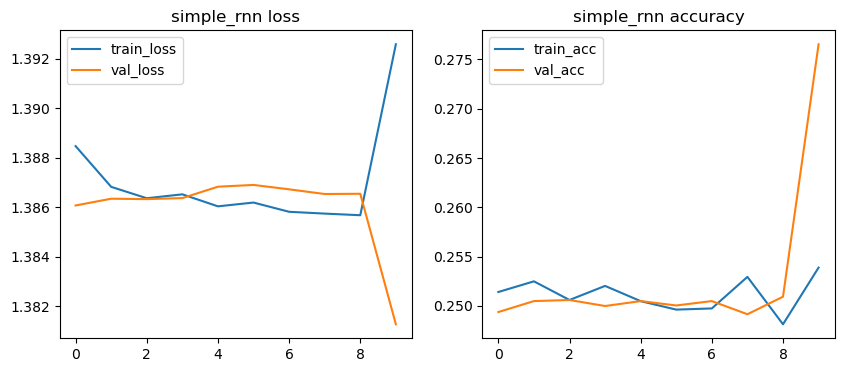

Training model: lstm vocab: 20000 edited: False
Epoch 1/10
840/840 - 120s - 142ms/step - accuracy: 0.2490 - loss: 1.3869 - val_accuracy: 0.2503 - val_loss: 1.3871
Epoch 2/10
840/840 - 117s - 139ms/step - accuracy: 0.2513 - loss: 1.3866 - val_accuracy: 0.2508 - val_loss: 1.3863
Epoch 3/10
840/840 - 119s - 141ms/step - accuracy: 0.2488 - loss: 1.3878 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 4/10
840/840 - 120s - 143ms/step - accuracy: 0.2510 - loss: 1.3858 - val_accuracy: 0.2519 - val_loss: 1.3851
Epoch 5/10
840/840 - 119s - 142ms/step - accuracy: 0.2738 - loss: 1.3609 - val_accuracy: 0.4480 - val_loss: 1.1311
Epoch 6/10
840/840 - 128s - 153ms/step - accuracy: 0.5157 - loss: 1.0132 - val_accuracy: 0.5919 - val_loss: 0.8762
Epoch 7/10
840/840 - 125s - 149ms/step - accuracy: 0.6340 - loss: 0.7868 - val_accuracy: 0.6543 - val_loss: 0.7450
Epoch 8/10
840/840 - 125s - 149ms/step - accuracy: 0.6846 - loss: 0.6593 - val_accuracy: 0.6890 - val_loss: 0.6705
Epoch 9/10
840/840 - 128s - 152m

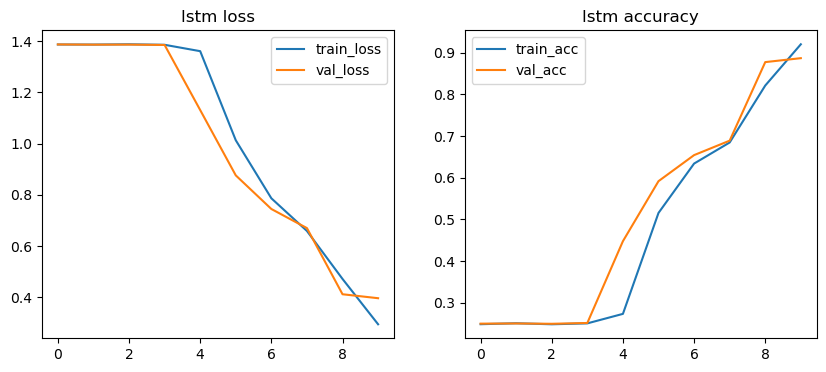

Training model: bilstm vocab: 20000 edited: False
Epoch 1/10
840/840 - 317s - 377ms/step - accuracy: 0.8270 - loss: 0.4772 - val_accuracy: 0.9032 - val_loss: 0.2975
Epoch 2/10
840/840 - 304s - 362ms/step - accuracy: 0.9241 - loss: 0.2385 - val_accuracy: 0.9009 - val_loss: 0.2961
Epoch 3/10
840/840 - 337s - 401ms/step - accuracy: 0.9391 - loss: 0.1907 - val_accuracy: 0.8994 - val_loss: 0.3021
Epoch 4/10
840/840 - 296s - 352ms/step - accuracy: 0.9506 - loss: 0.1548 - val_accuracy: 0.8960 - val_loss: 0.3432
Epoch 5/10
840/840 - 291s - 347ms/step - accuracy: 0.9581 - loss: 0.1297 - val_accuracy: 0.8935 - val_loss: 0.3584
Epoch 6/10
840/840 - 292s - 348ms/step - accuracy: 0.9638 - loss: 0.1101 - val_accuracy: 0.8917 - val_loss: 0.3764
Epoch 7/10
840/840 - 292s - 347ms/step - accuracy: 0.9688 - loss: 0.0932 - val_accuracy: 0.8885 - val_loss: 0.4272
Epoch 8/10
840/840 - 291s - 347ms/step - accuracy: 0.9745 - loss: 0.0766 - val_accuracy: 0.8858 - val_loss: 0.4439
Epoch 9/10
840/840 - 291s - 34

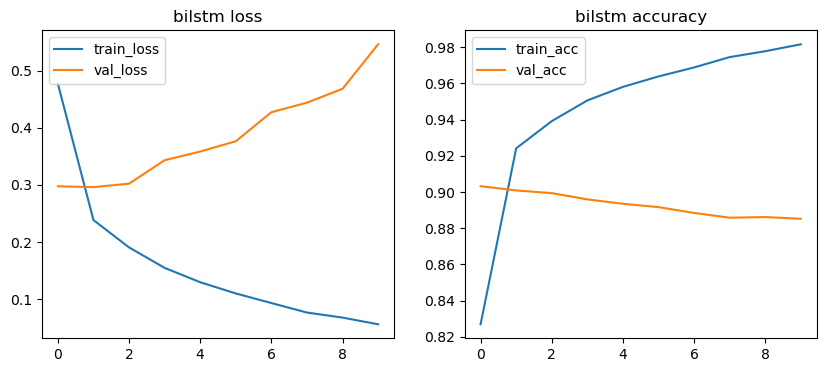


--- vocab_size: 20000 edited_vocab: True  ---
Training model: dense vocab: 20000 edited: True
Epoch 1/10
840/840 - 13s - 15ms/step - accuracy: 0.6287 - loss: 0.8866 - val_accuracy: 0.8842 - val_loss: 0.3867
Epoch 2/10
840/840 - 11s - 13ms/step - accuracy: 0.8798 - loss: 0.3802 - val_accuracy: 0.8938 - val_loss: 0.3292
Epoch 3/10
840/840 - 11s - 13ms/step - accuracy: 0.9004 - loss: 0.3177 - val_accuracy: 0.9014 - val_loss: 0.3033
Epoch 4/10
840/840 - 11s - 13ms/step - accuracy: 0.9124 - loss: 0.2790 - val_accuracy: 0.8903 - val_loss: 0.3321
Epoch 5/10
840/840 - 11s - 13ms/step - accuracy: 0.9180 - loss: 0.2594 - val_accuracy: 0.9006 - val_loss: 0.2975
Epoch 6/10
840/840 - 11s - 13ms/step - accuracy: 0.9232 - loss: 0.2391 - val_accuracy: 0.9007 - val_loss: 0.3016
Epoch 7/10
840/840 - 11s - 13ms/step - accuracy: 0.9272 - loss: 0.2233 - val_accuracy: 0.8978 - val_loss: 0.3179
Epoch 8/10
840/840 - 11s - 13ms/step - accuracy: 0.9289 - loss: 0.2164 - val_accuracy: 0.8851 - val_loss: 0.3418
E

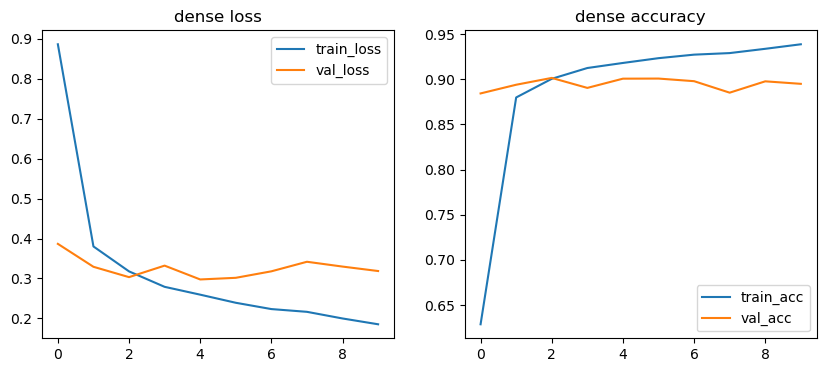

Training model: cnn1d vocab: 20000 edited: True
Epoch 1/10
840/840 - 39s - 46ms/step - accuracy: 0.8303 - loss: 0.4807 - val_accuracy: 0.9006 - val_loss: 0.2971
Epoch 2/10
840/840 - 36s - 43ms/step - accuracy: 0.9258 - loss: 0.2369 - val_accuracy: 0.9007 - val_loss: 0.3008
Epoch 3/10
840/840 - 37s - 44ms/step - accuracy: 0.9499 - loss: 0.1596 - val_accuracy: 0.8936 - val_loss: 0.3355
Epoch 4/10
840/840 - 36s - 43ms/step - accuracy: 0.9689 - loss: 0.1013 - val_accuracy: 0.8887 - val_loss: 0.4056
Epoch 5/10
840/840 - 36s - 43ms/step - accuracy: 0.9810 - loss: 0.0631 - val_accuracy: 0.8901 - val_loss: 0.4795
Epoch 6/10
840/840 - 37s - 44ms/step - accuracy: 0.9880 - loss: 0.0422 - val_accuracy: 0.8883 - val_loss: 0.5679
Epoch 7/10
840/840 - 37s - 44ms/step - accuracy: 0.9907 - loss: 0.0302 - val_accuracy: 0.8867 - val_loss: 0.6167
Epoch 8/10
840/840 - 37s - 44ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.8853 - val_loss: 0.6838
Epoch 9/10
840/840 - 37s - 44ms/step - accuracy:

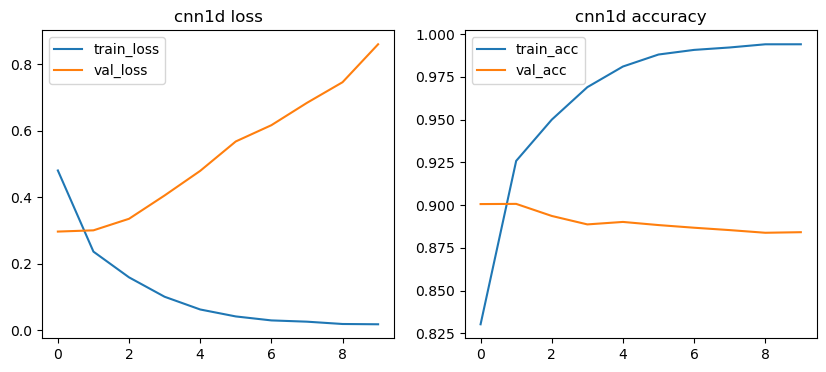

Training model: simple_rnn vocab: 20000 edited: True
Epoch 1/10
840/840 - 48s - 57ms/step - accuracy: 0.2593 - loss: 1.3884 - val_accuracy: 0.2514 - val_loss: 1.3863
Epoch 2/10
840/840 - 45s - 54ms/step - accuracy: 0.2550 - loss: 1.3870 - val_accuracy: 0.2504 - val_loss: 1.3876
Epoch 3/10
840/840 - 45s - 54ms/step - accuracy: 0.2498 - loss: 1.3869 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 4/10
840/840 - 45s - 54ms/step - accuracy: 0.2535 - loss: 1.3867 - val_accuracy: 0.2501 - val_loss: 1.3863
Epoch 5/10
840/840 - 47s - 56ms/step - accuracy: 0.2485 - loss: 1.3866 - val_accuracy: 0.2623 - val_loss: 1.3863
Epoch 6/10
840/840 - 47s - 55ms/step - accuracy: 0.2511 - loss: 1.3875 - val_accuracy: 0.2815 - val_loss: 1.3821
Epoch 7/10
840/840 - 47s - 56ms/step - accuracy: 0.3372 - loss: 1.3514 - val_accuracy: 0.4936 - val_loss: 1.2240
Epoch 8/10
840/840 - 47s - 56ms/step - accuracy: 0.5431 - loss: 1.1634 - val_accuracy: 0.5202 - val_loss: 1.1901
Epoch 9/10
840/840 - 48s - 57ms/step - accu

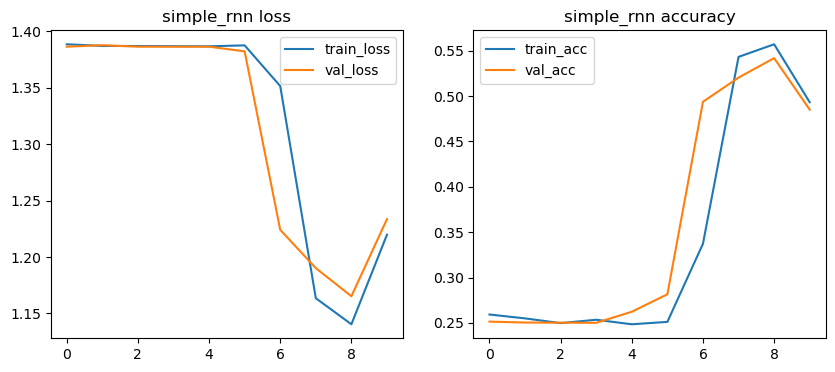

Training model: lstm vocab: 20000 edited: True
Epoch 1/10
840/840 - 113s - 134ms/step - accuracy: 0.2518 - loss: 1.3870 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 2/10
840/840 - 110s - 131ms/step - accuracy: 0.2481 - loss: 1.3868 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 3/10
840/840 - 113s - 134ms/step - accuracy: 0.2501 - loss: 1.3866 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 4/10
840/840 - 111s - 132ms/step - accuracy: 0.2483 - loss: 1.3866 - val_accuracy: 0.2503 - val_loss: 1.3863
Epoch 5/10
840/840 - 111s - 133ms/step - accuracy: 0.2492 - loss: 1.3865 - val_accuracy: 0.2502 - val_loss: 1.3862
Epoch 6/10
840/840 - 114s - 136ms/step - accuracy: 0.2499 - loss: 1.3863 - val_accuracy: 0.2502 - val_loss: 1.3861
Epoch 7/10
840/840 - 112s - 133ms/step - accuracy: 0.2494 - loss: 1.3863 - val_accuracy: 0.2499 - val_loss: 1.3857
Epoch 8/10
840/840 - 113s - 135ms/step - accuracy: 0.2509 - loss: 1.3861 - val_accuracy: 0.2505 - val_loss: 1.3858
Epoch 9/10
840/840 - 113s - 134ms

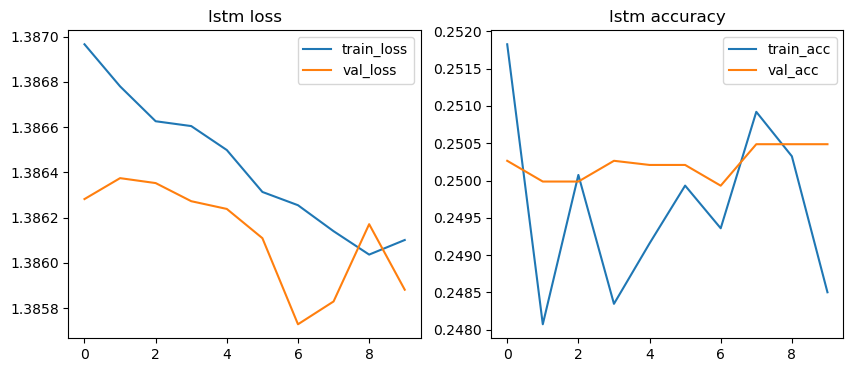

Training model: bilstm vocab: 20000 edited: True
Epoch 1/10
840/840 - 322s - 384ms/step - accuracy: 0.8416 - loss: 0.4461 - val_accuracy: 0.9044 - val_loss: 0.2947
Epoch 2/10
840/840 - 309s - 367ms/step - accuracy: 0.9257 - loss: 0.2304 - val_accuracy: 0.9020 - val_loss: 0.2902
Epoch 3/10
840/840 - 322s - 383ms/step - accuracy: 0.9425 - loss: 0.1773 - val_accuracy: 0.8996 - val_loss: 0.3038
Epoch 4/10
840/840 - 397s - 473ms/step - accuracy: 0.9527 - loss: 0.1432 - val_accuracy: 0.8944 - val_loss: 0.3429
Epoch 5/10
840/840 - 324s - 385ms/step - accuracy: 0.9617 - loss: 0.1152 - val_accuracy: 0.8885 - val_loss: 0.3706
Epoch 6/10
840/840 - 1558s - 2s/step - accuracy: 0.9683 - loss: 0.0938 - val_accuracy: 0.8873 - val_loss: 0.4531
Epoch 7/10
840/840 - 692s - 824ms/step - accuracy: 0.9727 - loss: 0.0793 - val_accuracy: 0.8885 - val_loss: 0.4518
Epoch 8/10
840/840 - 1061s - 1s/step - accuracy: 0.9773 - loss: 0.0657 - val_accuracy: 0.8838 - val_loss: 0.5041
Epoch 9/10
840/840 - 511s - 608ms/s

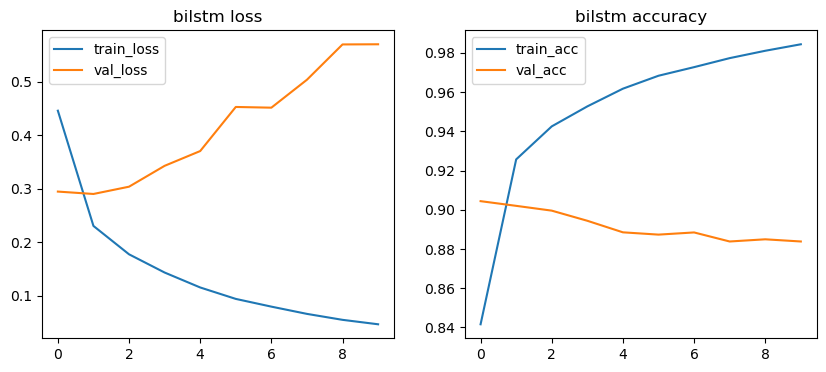

In [23]:
results = []
for vocab_size in VOCAB_SIZES:
    for edit_mode in EDIT_VOCAB_MODES:
        print("\n--- vocab_size:", vocab_size, "edited_vocab:", edit_mode, " ---")
        # Build tokenizer depending on edit_mode
        if edit_mode:
            # remove stopwords by removing them from training texts before fitting tokenizer
            X_train_for_token = [" ".join([w for w in s.split() if w not in STOPWORDS]) for s in X_train_clean]
        else:
            X_train_for_token = X_train_clean

        tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
        tokenizer.fit_on_texts(X_train_for_token)

        # Prepare sequences (apply same cleaning rule to val/test)
        def texts_to_pad(texts_in):
            if edit_mode:
                texts_proc = [" ".join([w for w in basic_clean(t).split() if w not in STOPWORDS]) for t in texts_in]
            else:
                texts_proc = [basic_clean(t) for t in texts_in]
            seq = tokenizer.texts_to_sequences(texts_proc)
            return pad_sequences(seq, maxlen=MAXLEN, padding='post', truncating='post')

        Xtr = texts_to_pad(X_train)
        Xvl = texts_to_pad(X_val)
        Xte = texts_to_pad(X_test)

        for model_name in MODEL_NAMES:
            print("Training model:", model_name, "vocab:", vocab_size, "edited:", edit_mode)
            if model_name == "dense":
                model = make_dense_model(vocab_size, embedding_dim=64)
            elif model_name == "cnn1d":
                model = make_cnn1d_model(vocab_size, embedding_dim=64)
            elif model_name == "simple_rnn":
                model = make_simple_rnn_model(vocab_size, embedding_dim=64)
            elif model_name == "lstm":
                model = make_lstm_model(vocab_size, embedding_dim=64, bidirectional=False)
            elif model_name == "bilstm":
                model = make_lstm_model(vocab_size, embedding_dim=64, bidirectional=True)
            else:
                raise ValueError("Unknown model " + model_name)

            # Train (you can change epochs)
            t0 = time.time()
            history = model.fit(Xtr, y_train, validation_data=(Xvl, y_val),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
            t1 = time.time()
            elapsed = t1 - t0

            # Evaluate on test
            test_loss, test_acc = model.evaluate(Xte, y_test, verbose=0)

            # Save a compact result entry
            r = {
                "model": model_name,
                "vocab_size": vocab_size,
                "edited_vocab": edit_mode,
                "epochs": EPOCHS,
                "batch_size": BATCH_SIZE,
                "train_time_sec": round(elapsed, 2),
                "train_acc_final": float(history.history['accuracy'][-1]),
                "val_acc_final": float(history.history['val_accuracy'][-1]),
                "test_acc": float(test_acc),
                "test_loss": float(test_loss)
            }
            results.append(r)

            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.plot(history.history['loss'], label='train_loss')
            plt.plot(history.history['val_loss'], label='val_loss')
            plt.title(f"{model_name} loss")
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(history.history['accuracy'], label='train_acc')
            plt.plot(history.history['val_accuracy'], label='val_acc')
            plt.title(f"{model_name} accuracy")
            plt.legend()
            plt.show()

In [26]:
results_df = pd.DataFrame(results)
print("\nALL RESULTS:")
display(results_df)
results_df.to_csv("experiment_results.csv", index=False)
# with open("/content/experiment_results.json", "w") as f:
#     json.dump(results, f, indent=2)
# print("Saved results to /content/experiment_results.csv and .json")


ALL RESULTS:


,model,vocab_size,edited_vocab,epochs,batch_size,train_time_sec,train_acc_final,val_acc_final,test_acc,test_loss
0,dense,5000,False,10,100,69.45,0.911344,0.881895,0.885833,0.337965
1,cnn1d,5000,False,10,100,334.03,0.989226,0.890006,0.895556,0.621727
2,simple_rnn,5000,False,10,100,298.63,0.264277,0.271929,0.272444,1.383068
3,lstm,5000,False,10,100,959.37,0.908820,0.885617,0.889778,0.329854
4,bilstm,5000,False,10,100,2304.47,0.951630,0.888839,0.893333,0.376863
5,dense,5000,True,10,100,80.35,0.909844,0.894673,0.900167,0.295265
6,cnn1d,5000,True,10,100,349.89,0.989547,0.880673,0.885500,0.691762
7,simple_rnn,5000,True,10,100,319.51,0.581186,0.681240,0.675278,0.898697
8,lstm,5000,True,10,100,1052.40,0.249241,0.249986,0.250000,1.386231
9,bilstm,5000,True,10,100,3252.36,0.954023,0.883284,0.887389,0.396415
